Choosing MW-mass galaxies

In [1]:
import numpy as np
import scipy.stats
import h5py
import sys
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
sys.path.insert(0,"../")
import illustris_python as il

In [3]:
from astropy.cosmology import FlatLambdaCDM

redshiftdata1=np.genfromtxt('data/redshift_TNG', dtype=[('snap','<i8'), ('redshift','<f8')])

def find_redshift(snap):
    arg=np.where(redshiftdata1['snap']==snap)[0]
    if len(arg)>0:
        return redshiftdata1['redshift'][arg[0]]

def redshift(scale):
    return 1.0/scale - 1.0

cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3089)

def age(redshift):
    age1=cosmo.age(redshift)
    return 13.7 - age1.value

In [5]:
# Enter in the current path of the files
basePath = '/home/rdsouza/SIMS/TNG50/output/'

In [6]:
# Load all the subhaloes
fields = ['SubhaloMassType','SubhaloFlag','SubhaloParent','SubhaloGrNr','SubhaloPos']
subhalos = il.groupcat.loadSubhalos(basePath, 99, fields=fields)

In [7]:
h0=0.6774
dm=subhalos['SubhaloMassType'][:,1]*1e10/h0
sm=subhalos['SubhaloMassType'][:,4]*1e10/h0
mask_sub=subhalos['SubhaloFlag'][:]
parent=subhalos['SubhaloParent'][:]
pos=subhalos['SubhaloPos'][:]/h0
GrpNo=subhalos['SubhaloGrNr'][:]

In [9]:
# Load the Group Catalog with information about which subhalos are centrals
groups = il.groupcat.loadHalos(basePath,99,fields=['GroupFirstSub','Group_M_Crit200'])
GroupFirstSub=groups['GroupFirstSub']
group_dm200  =groups['Group_M_Crit200']*1e10/h0

In [11]:
# Dark Matter M_200 of all the subhaloes 
dm200=np.zeros_like(dm)
for i in range(len(dm200)):
    dm200[i]=group_dm200[GrpNo[i]]

In [12]:
mask_all=np.where(dm200)[0]

In [16]:
# find the aperture masses of all the subhaloes
apmasses=h5py.File('data/aperture_masses.hdf5')
apID=apmasses['Snapshot_99']['SubfindID'][:]
apm30=apmasses['Snapshot_99']['SubhaloStellarMass_in_r30pkpc'][:]
apmasses.close()

In [17]:

sm30=-np.ones_like(sm)
for i in range(len(apID)):
    sm30[apID[i]]=apm30[i]

In [18]:
# Load the stellar mass fractions calculated with Rodrigues-Gomes et al.
fracmasses=h5py.File('/home/rdsouza/SIMS/TNG50/postprocessing/StellarAssembly/stellar_assembly.hdf5')
exsitu=fracmasses['Snapshot_99']['StellarMassFromCompletedMergers'][:]
totalmass=fracmasses['Snapshot_99']['StellarMassTotal'][:]
fracmasses.close()
exsitufrac=exsitu/totalmass

/home/rdsouza/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/rdsouza/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Note that:

- In D'Souza & Bell 2018, we chose M31-like galaxies with the following conditions: 10.7 < log(M*) < 11.3, 11.86 < log(M_DM_200) < 12.34 and (M_acc/M*) < 0.5. 

- Engler et al (as well as other Pillepich's papers) use a differnent selection function made up of 3 conditions: a) M* ~ 10.5 < log(M*) < 11.2, and M_200c< 10^13 b) disky morphology and c) Isolation criterion: No other massive galaxies with M* > 10^10.5 are allowed within a distance of 500 kpc of the MW/M31-like candidates.

- In this notebook, we follow the condition of Engler et al... and apply the disk morphology later. 

191


/home/rdsouza/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/home/rdsouza/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


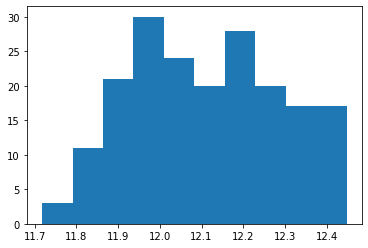

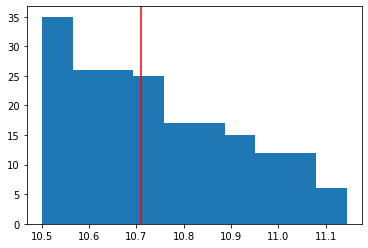

In [20]:
# First mask of DM
mask_dm= np.where((sm30>=10**10.5) & (sm30<=10**11.3) & (dm200>=10**11.7) & (dm200<=10**12.45) & (exsitufrac<0.5) & (exsitufrac>0) )[0]
print(len(dm200[mask_dm]))
plt.hist(np.log10(dm200[mask_dm]))
plt.show()
plt.hist(np.log10(sm30[mask_dm]))
med=np.median(sm30[mask_dm])
plt.axvline(np.log10(med),c='r')

In [ ]:
# find which of these galaxies are isolated.

In [22]:
def distance(pos1):
    #return np.sqrt(np.sum(pos1[0,:]**2 + pos1[1,:]**2 + pos1[2,:]**2,axis=1))
    return (np.sqrt(pos1[:,0]**2 + pos1[:,1]**2 + pos1[:,2]**2))

In [23]:
mask_dm= np.where((sm30>=10**10.5) & (sm30<=10**11.3) & (dm200>=10**11.7) & (dm200<=10**12.45) & (exsitufrac<0.5) & (exsitufrac>0) )[0]
isolate=np.zeros_like(mask_dm)
for i,e in enumerate(mask_dm):
    maske=np.where(mask_all!=e)[0]
    dist1=distance(pos[maske]-pos[e])/h0
    arg1=np.where((dist1<500) & (sm30[maske]>10**10.5))[0]
    isolate[i]=len(arg1)

/home/rdsouza/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/home/rdsouza/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [ ]:
np.where(isolate==0)

In [ ]:
mask_dm

In [ ]:
mask_isolate=(isolate==0)
mask_dmi = mask_dm[mask_isolate]

In [24]:
len(mask_dmi)

183

In [54]:
mask_dmi

array([402555, 428177, 432106, 434356, 435752, 436932, 440407, 443049,
       445626, 446665, 449659, 450916, 452978, 454171, 454172, 456326,
       458470, 459557, 459558, 461785, 462710, 464163, 465255, 467415,
       468590, 469487, 470345, 471248, 471996, 472548, 473329, 475016,
       475619, 476266, 477328, 478216, 479290, 479938, 481428, 482155,
       482889, 483594, 484448, 485056, 486046, 487742, 488530, 489206,
       490079, 490814, 491426, 492244, 492876, 494011, 494709, 495451,
       496186, 497557, 498522, 499704, 500577, 501208, 501725, 502371,
       502995, 503437, 503987, 504559, 505100, 505586, 506151, 506720,
       507784, 508538, 509091, 509709, 510273, 510585, 511303, 511920,
       512425, 513105, 513845, 514272, 514829, 515296, 515695, 516101,
       516760, 517271, 517899, 518682, 519311, 520885, 521429, 521803,
       522530, 522983, 523548, 523889, 524506, 525002, 525533, 526029,
       526478, 527309, 528322, 528836, 529365, 530330, 530852, 531320,
      

In [26]:
np.save('data/MWM31SubfindID.npy',mask_dmi)

Note: 
a) The final sample does not have any selection based on disk morphology.
b) To select disk-like galaxies, it is best to use the circularity parameter 'CircAbove07Frac' described in Appendix C1. of Nelson et al. 2015.


In [27]:
file1=h5py.File('data/stellar_circs.hdf5')

In [28]:
file1['Snapshot_99'].keys()

<KeysViewHDF5 ['CircAbove07Frac', 'CircAbove07Frac_allstars', 'CircAbove07MinusBelowNeg07Frac', 'CircAbove07MinusBelowNeg07Frac_allstars', 'CircTwiceBelow0Frac', 'CircTwiceBelow0Frac_allstars', 'MassTensorEigenVals', 'ReducedMassTensorEigenVals', 'SpecificAngMom', 'SpecificAngMom_allstars', 'SubfindID']>

In [55]:
for ai in mask_dmi:
    arg=np.where(file1['Snapshot_99']['SubfindID'][:]==ai)[0]
    if len(arg)>0:
        circ=file1['Snapshot_99']['CircAbove07Frac'][arg[0]]
        if circ>0.5:
            print(ai,np.log10(sm30[ai]),circ,exsitufrac[ai])


402555 11.110187 0.5318445 0.07493718
432106 11.143914 0.5153916 0.38184068
436932 11.055335 0.6065633 0.19406436
449659 10.745893 0.5445174 0.039814796
454171 10.870092 0.58501893 0.049203828
456326 11.024408 0.5910749 0.27854836
467415 11.0399885 0.5301311 0.07621643
473329 10.987834 0.6119577 0.14090784
477328 10.745666 0.5268817 0.22985488
478216 10.762802 0.576322 0.117937595
479938 10.782257 0.50326025 0.2740038
485056 10.916559 0.5535872 0.115465775
488530 11.028842 0.56993145 0.23684911
491426 10.927635 0.59644794 0.06831498
494709 10.866175 0.58718604 0.19753568
500577 10.528428 0.68909717 0.012524509
501208 10.922474 0.5330357 0.035761528
501725 10.812737 0.6637721 0.30369645
502995 10.882951 0.62493795 0.17336702
503437 10.805853 0.59741217 0.0986487
505586 11.014021 0.59498465 0.20204836
509091 10.696999 0.5981726 0.17583537
510273 10.82456 0.54342055 0.3112789
510585 10.694281 0.51397455 0.18601295
515695 10.955694 0.5515166 0.38691282
518682 10.672676 0.57039213 0.181205
